In [ ]:
import torch

In [ ]:
D_in, H,H2, D_out = 784, 400,200, 47

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),
)

In [ ]:
outputs = model(torch.randn(64, 784))
outputs.shape

torch.Size([64, 47])

In [ ]:
model.to("cuda")

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=47, bias=True)
)

In [ ]:
from sklearn.datasets import fetch_openml

# descarga datos

mnist = fetch_openml('EMNIST_Balanced', version=1)
X, Y = mnist["data"], mnist["target"]

X.shape, Y.shape

/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


((131600, 784), (131600,))

In [ ]:
import numpy as np
X=np.array(X)
Y= np.array(Y)

In [ ]:

# normalización y split

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(int), Y[60000:].astype(int)

In [ ]:
# función de pérdida y derivada

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [ ]:
# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

# bucle entrenamiento
epochs = 1000
lr = 0.8
log_each = 10
l = []
for e in range(1, epochs+1): 
    
    # forward
    y_pred = model(X_t)

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())
    
    # ponemos a cero los gradientes
    model.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/1000 Loss 3.80065
Epoch 20/1000 Loss 3.58534
Epoch 30/1000 Loss 3.61641
Epoch 40/1000 Loss 3.52516
Epoch 50/1000 Loss 3.39841
Epoch 60/1000 Loss 3.25246
Epoch 70/1000 Loss 3.07946
Epoch 80/1000 Loss 2.92429
Epoch 90/1000 Loss 2.78099
Epoch 100/1000 Loss 2.64786
Epoch 110/1000 Loss 2.53297
Epoch 120/1000 Loss 2.42915
Epoch 130/1000 Loss 2.33817
Epoch 140/1000 Loss 2.25420
Epoch 150/1000 Loss 2.17667
Epoch 160/1000 Loss 2.10566
Epoch 170/1000 Loss 2.03963
Epoch 180/1000 Loss 1.97932
Epoch 190/1000 Loss 1.92624
Epoch 200/1000 Loss 1.87382
Epoch 210/1000 Loss 1.82669
Epoch 220/1000 Loss 1.78207
Epoch 230/1000 Loss 1.74090
Epoch 240/1000 Loss 1.70121
Epoch 250/1000 Loss 1.66405
Epoch 260/1000 Loss 1.62888
Epoch 270/1000 Loss 1.59756
Epoch 280/1000 Loss 1.56526
Epoch 290/1000 Loss 1.53604
Epoch 300/1000 Loss 1.50867
Epoch 310/1000 Loss 1.48077
Epoch 320/1000 Loss 1.45548
Epoch 330/1000 Loss 1.43132
Epoch 340/1000 Loss 1.40983
Epoch 350/1000 Loss 1.38645
Epoch 360/1000 Loss 1.36498
E

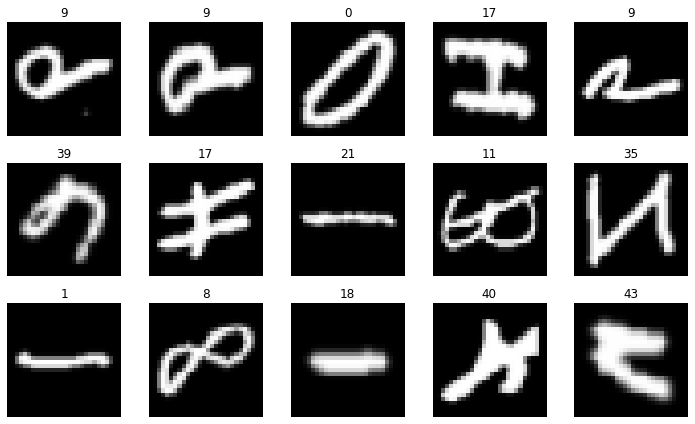

In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.8302653631284916

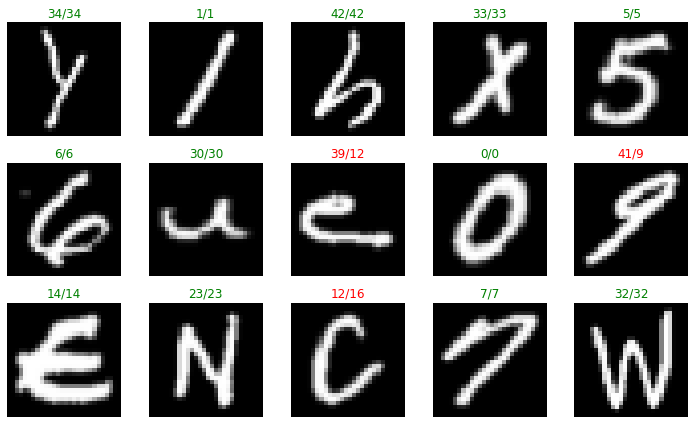

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        img= img.reshape(28,28)
        img = np.fliplr(img)
        img=np.rot90(img)
       
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()